## Homework 4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline

In [2]:
lalonde = pd.read_csv('lalonde.csv', index_col=0)
lalonde.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


## 1. A naive analysis

In [3]:
treated = lalonde[lalonde['treat'] == 1]
untreated = lalonde[lalonde['treat'] == 0]

In [4]:
treated_income = treated[['re78']]
untreated_income = untreated[['re78']]

In [5]:
treated_income.describe()

,re78
count,185.000000
mean,6349.143530
std,7867.402218
min,0.000000
25%,485.229800
50%,4232.309000
75%,9642.999000
max,60307.930000


In [6]:
untreated_income.describe()

,re78
count,429.000000
mean,6984.169742
std,7294.161791
min,0.000000
25%,220.181300
50%,4975.505000
75%,11688.820000
max,25564.670000


In [7]:
treated_ratio = int(treated_income.count()/(untreated_income.count()+ treated_income.count()) * 100)
print("Ratio of treated people = " + str(treated_ratio) + "%")

Ratio of treated people = 30%


**We see that out of the 614 samples, there is only 185 samples (30%) who are treated (did the the job traning program).**

In [8]:
def compare_distributions(s1, s2, feature, title):
    plt.figure(figsize = (10,8))
    plt.hist([s1[feature], s2[feature]], edgecolor='k', stacked= False)
    plt.legend(['No Treatment','Treatment'])
    plt.title('Treated, Untreated subjects by ' + title)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()
    print("Satistics of Untreated subjects by " + title + "\n")
    print(str(s1[e].describe()) + "\n\n")

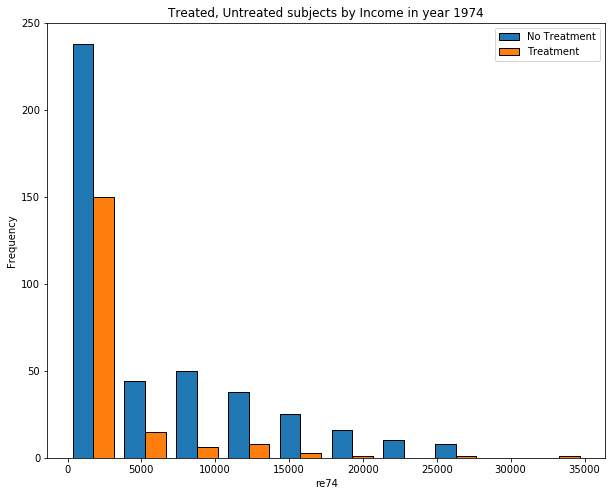

Satistics of Untreated subjects by Income in year 1974

count      429.000000
mean      5619.236506
std       6788.750796
min          0.000000
25%          0.000000
50%       2547.047000
75%       9277.128000
max      25862.320000
Name: re74, dtype: float64




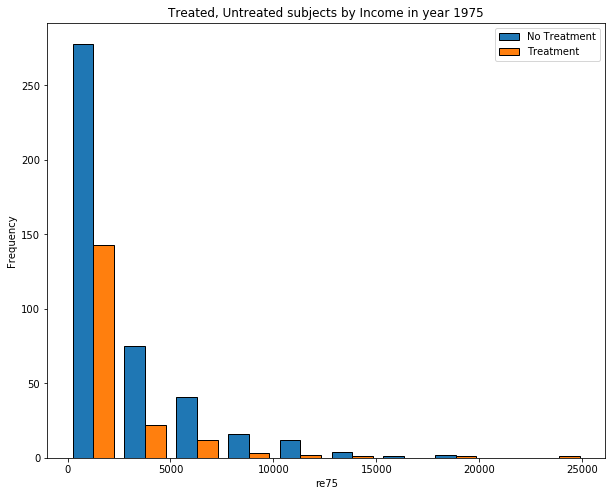

Satistics of Untreated subjects by Income in year 1975

count      429.000000
mean      2466.484443
std       3291.996183
min          0.000000
25%          0.000000
50%       1086.726000
75%       3881.419000
max      18347.230000
Name: re75, dtype: float64




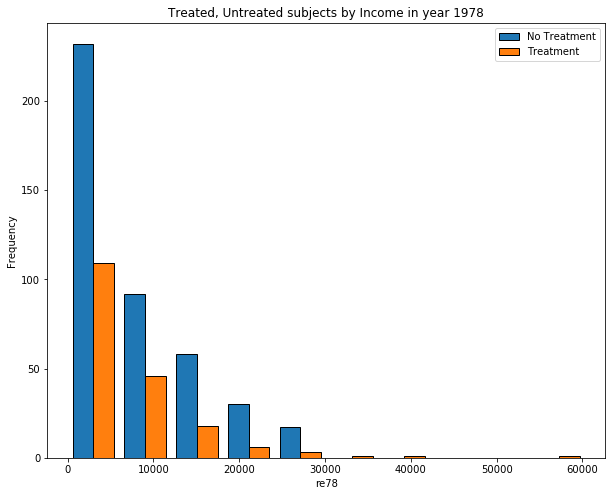

Satistics of Untreated subjects by Income in year 1978

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64




In [9]:
earnings = ['re74','re75','re78']
for e in earnings:
    title = 'Income in year 19{}'.format(e[2:])
    compare_distributions(untreated, treated, e, title)

**The naive method says that the treatment is inefficient, since for any given income, there is more untreated people than treated ones.**

## 2. A closer look at the data 

We now compare the distribution of each feature in the treated group with its distribution in the untreated group.

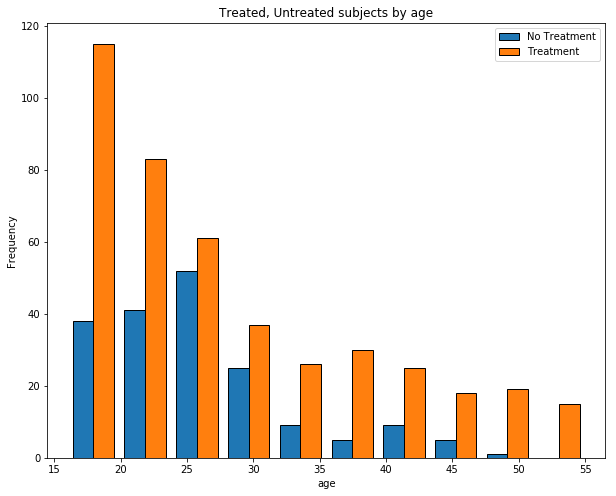

Satistics of Untreated subjects by age

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64




In [10]:
compare_distributions(treated, untreated, 'age', 'age')

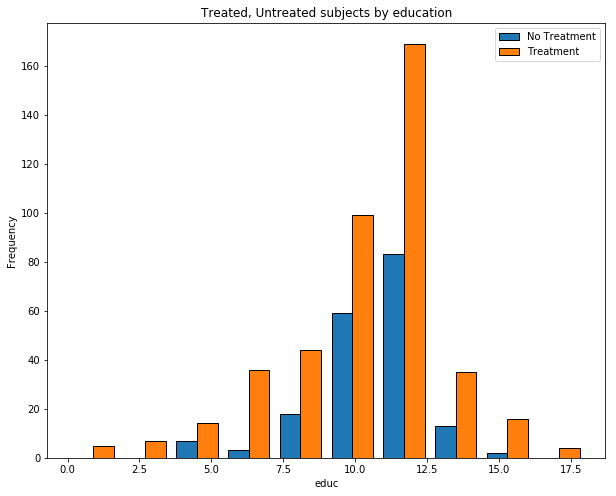

Satistics of Untreated subjects by education

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64




In [11]:
compare_distributions(treated, untreated, 'educ', 'education')

**Treatment/non treament by education is normally distributed with a small negative skew**

For the categorical (0/1) features ***race (black and hispanic), married & nondegree***, we will sum up the value of those features to get the count. 

In [12]:
treated.head(10)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899
NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940
NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000
NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580
NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220


In [13]:
def ratios(data , features):
    ones = []
    zeros = []
    for f in features:
        one = (data[f].values.sum()/data[f].count())*100
        zero = 100 - one
        ones.append(one)
        zeros.append(zero)
    return ones, zeros

In [47]:
def compare_feature_value(treated, untreated):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
    features = ['black', 'hispan', 'married', 'nodegree']
    ones, zeros = ratios(treated, features)
    n = [0, 1, 2, 3]
    title = 'treated subjects'
    data = [treated, untreated]
    for i in range(2):
        ones, zeros = ratios(data[i], features)
        if (i == 1):
            title = 'Un' + title
        plt.sca(ax[i])
        plt.xticks(n, features)
        plt.ylabel('Percentage of ' + title )
        plt.yticks( [0, 25, 50, 75, 100] )
        plt.bar(n, ones)
        plt.bar(n, zeros, bottom = ones)
        plt.title('Feature-wise ' + title)
        plt.legend(('Treated','Untreated'))

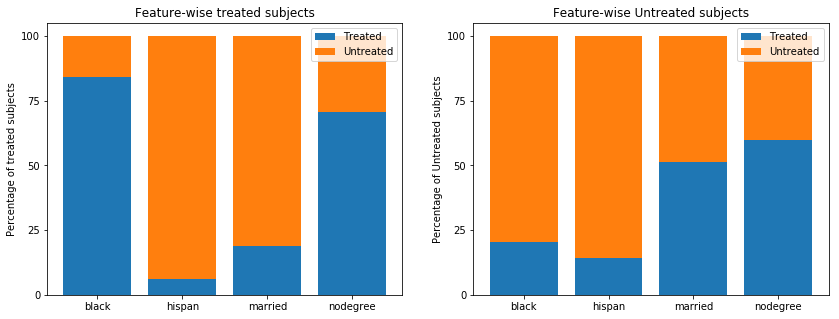

In [48]:
compare_feature_value(treated, untreated)

## 3. A propensity score model

In [15]:
lalonde.head(10)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899
NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940
NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000
NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580
NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220


Let us train our data to estimate the propensity score for each datapoint, i.e the probability of being treated (or not).

In [16]:
logistic = linear_model.LogisticRegression()
Z = lalonde['treat']
X = lalonde.drop('treat', axis=1)
logistic.fit(X,Z)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Once our data is trained, we now calculate the propensity scores:

In [17]:
score = logistic.predict_proba(X)
score_lalonde = lalonde.copy()
score_lalonde["prop_0"] = score[:,0]
score_lalonde["prop_1"] = score[:,1]
score_lalonde.head(10)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop_0,prop_1
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.541926,0.458074
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.848020,0.151980
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.249034,0.750966
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.325980,0.674020
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.329410,0.670590
NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0.288746,0.711254
NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,0.350384,0.649616
NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580,0.339566,0.660434
NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220,0.416180,0.583820


## 4. Balancing the dataset via matching

Now that we got our scores, let us split our dataframe into 2 groups as we did earlier: the treated group, and the control (untreated) group:

In [18]:
score_treated = score_lalonde[score_lalonde['treat'] == 1]
score_untreated = score_lalonde[score_lalonde['treat'] == 0]

In [19]:
A = score_treated.index
B = score_untreated.index

We will now match each data point from the treated group with exactly one data point from the control group.
In order to do that we first create a **Bipartite Graph G connecting all the points from the two groups**, and then extract a **one-to-one mapping** minimizing the sum of costs over all the edges.

We will now use the **Python networkx package** in order to construct a **Bipartite Graph G** consisting of **sets of vertices A & B**. Each *vertex* represent a datapoint in X, and each *edge* has a weight w. 
1. Let **A** be the set of all vertices consisting of propensity scores relative the treated group **(treat=1)**
2. Let **B** be the set of all vertices consisting of propensity scores relative the untreated group **(treat=0)**
3. We define the *weight* **w** of each edge **E = (Ai, Bj)** as the absolute value difference of the scores of the vertices **Ai** & **Bj**

In [20]:
import networkx as nx
from networkx.algorithms import bipartite

We now construct the vertices by mapping every element of A to every element of B

In [21]:
G = nx.Graph()
G.add_nodes_from(A, bipartite=0)
G.add_nodes_from(B, bipartite=1)

pair = []
for i in A:
    for j in B:
        G.add_edge(i,j, weight= - abs(score_treated.loc[i].prop_1 - score_untreated.loc[j].prop_1))

Next, we should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.


**N.B: Since the networkx package only offers a maximization function, we put a minus sign in front of the absolute value weight of our edges.** This way, we shall **maximize the opposite of the sum of scores**, which is *equivalent* to the problem of **minimizing the sum of scores.**  




In [22]:
match = nx.max_weight_matching(G, maxcardinality= True)

In [23]:
len(match)/2

185.0

We see that all the matches appears twice (for each edge (Ai, Bj) there is a corresponding one (Bj, Ai)), which is obviously the same. So we only take the first half.

We now extract the

In [37]:
a = sorted(list(match.keys()))[:185]
treated_matched_index = indexes
untreated_matched_index = []

#Retrieve the values corresponding the the keys in the matching
for i in treated_matched_index:
    untreated_matched_index.append(match.get(i))

In [41]:
#untreated_matched_index
treated_matched = score_treated.loc[a]
untreated_matched = score_untreated.loc[untreated_matched_index]

In [43]:
treated_matched.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop_0,prop_1
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.046,0.541926,0.458074
NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.070,0.913265,0.086735
NSW100,1,31,9,0,1,0,1,0.0,0.0,26817.600,0.787110,0.212890
NSW101,1,24,10,1,0,0,1,0.0,0.0,0.000,0.335811,0.664189
NSW102,1,26,10,1,0,0,1,0.0,0.0,9265.788,0.294593,0.705407


In [45]:
untreated_matched.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop_0,prop_1
id,,,,,,,,,,,,
PSID193,0,18,8,0,0,0,1,5023.56,1391.081,6756.166,0.817762,0.182238
PSID394,0,34,8,0,0,1,1,0.00,0.000,2664.341,0.913108,0.086892
PSID185,0,18,10,0,0,0,1,0.00,1491.339,237.914,0.812520,0.187480
PSID184,0,17,10,0,0,0,1,0.00,1503.871,7843.773,0.779763,0.220237
PSID389,0,18,11,1,0,0,1,0.00,0.000,7146.286,0.295241,0.704759


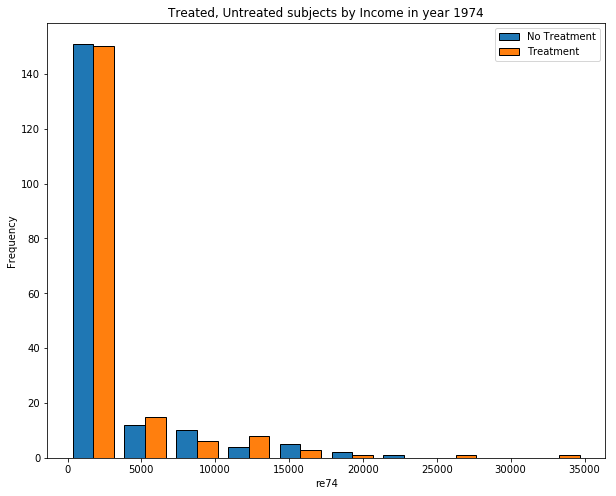

Satistics of Untreated subjects by Income in year 1974

count      185.000000
mean      2268.386180
std       4266.737051
min          0.000000
25%          0.000000
50%        336.993900
75%       2217.890000
max      21918.320000
Name: re74, dtype: float64




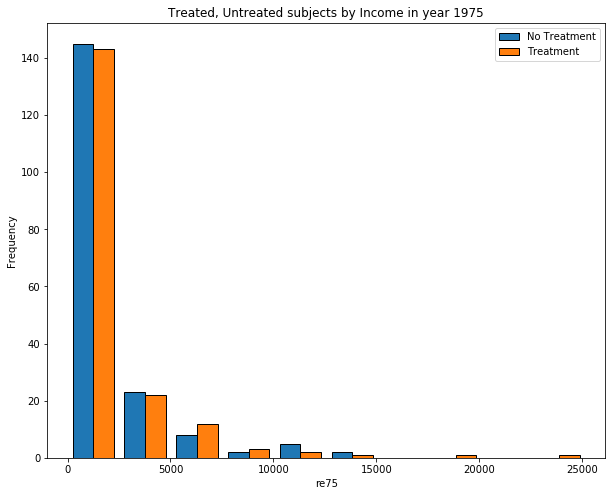

Satistics of Untreated subjects by Income in year 1975

count      185.000000
mean      1670.138671
std       2734.930726
min          0.000000
25%          0.000000
50%        470.854800
75%       1976.516000
max      13776.530000
Name: re75, dtype: float64




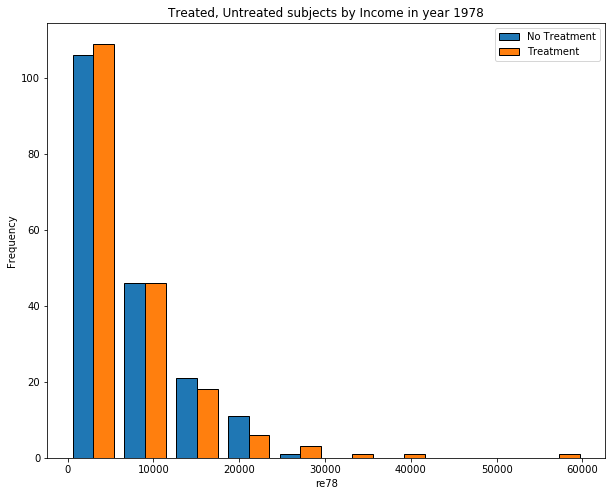

Satistics of Untreated subjects by Income in year 1978

count      185.000000
mean      5828.584903
std       6094.306306
min          0.000000
25%        237.914000
50%       4112.513000
75%       8957.978000
max      25564.670000
Name: re78, dtype: float64




In [46]:
earnings = ['re74','re75','re78']
for e in earnings:
    title = 'Income in year 19{}'.format(e[2:])
    compare_distributions(untreated_matched, treated_matched, e, title)

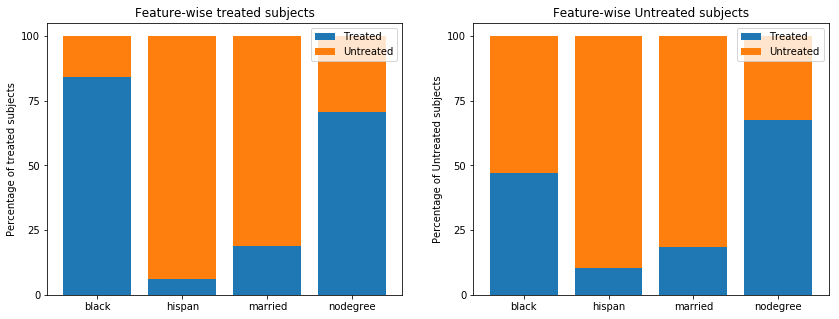

In [51]:
compare_feature_value(treated_matched, untreated_matched)

## 5. Balancing the groups further

TODO